<a href="https://colab.research.google.com/github/yazhinil/FMML20230017/blob/main/Module%2008%20Lab%2003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2024-03-25 13:42:50--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   133MB/s    in 0.5s    

2024-03-25 13:42:52 (133 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



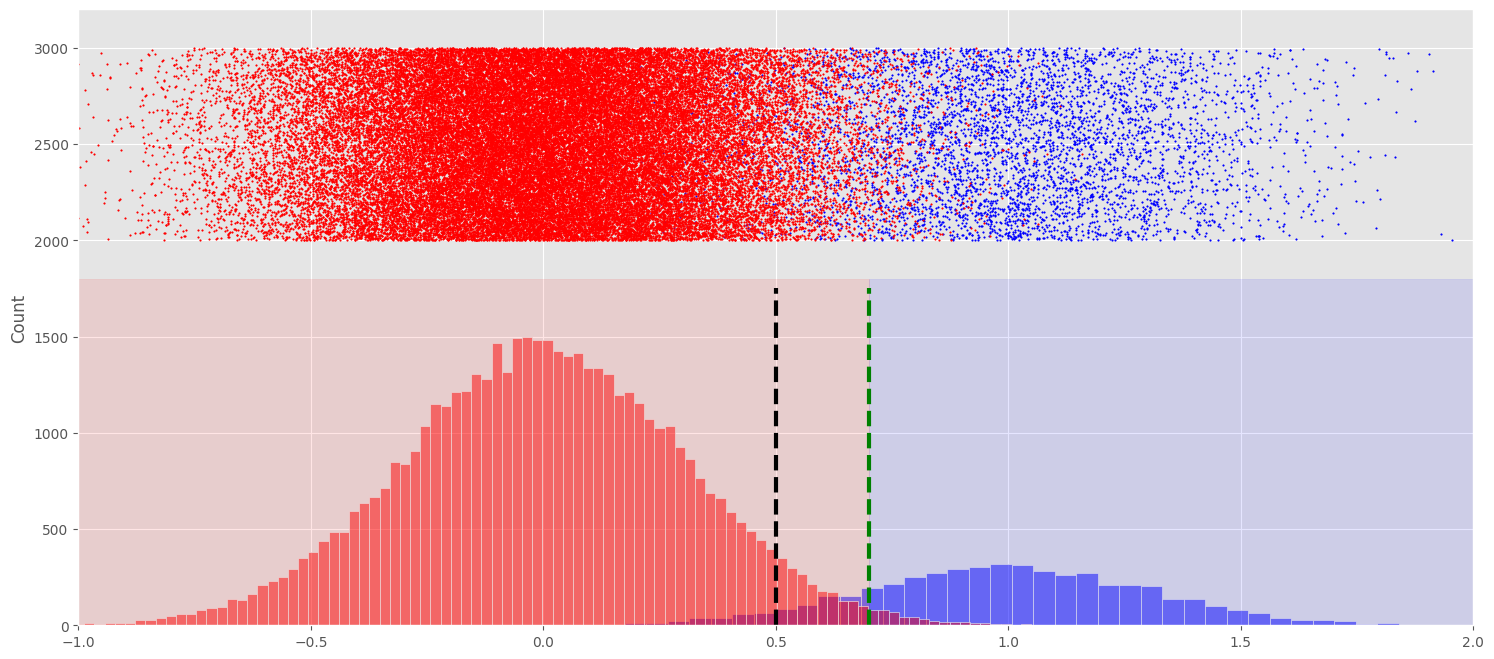

In [3]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

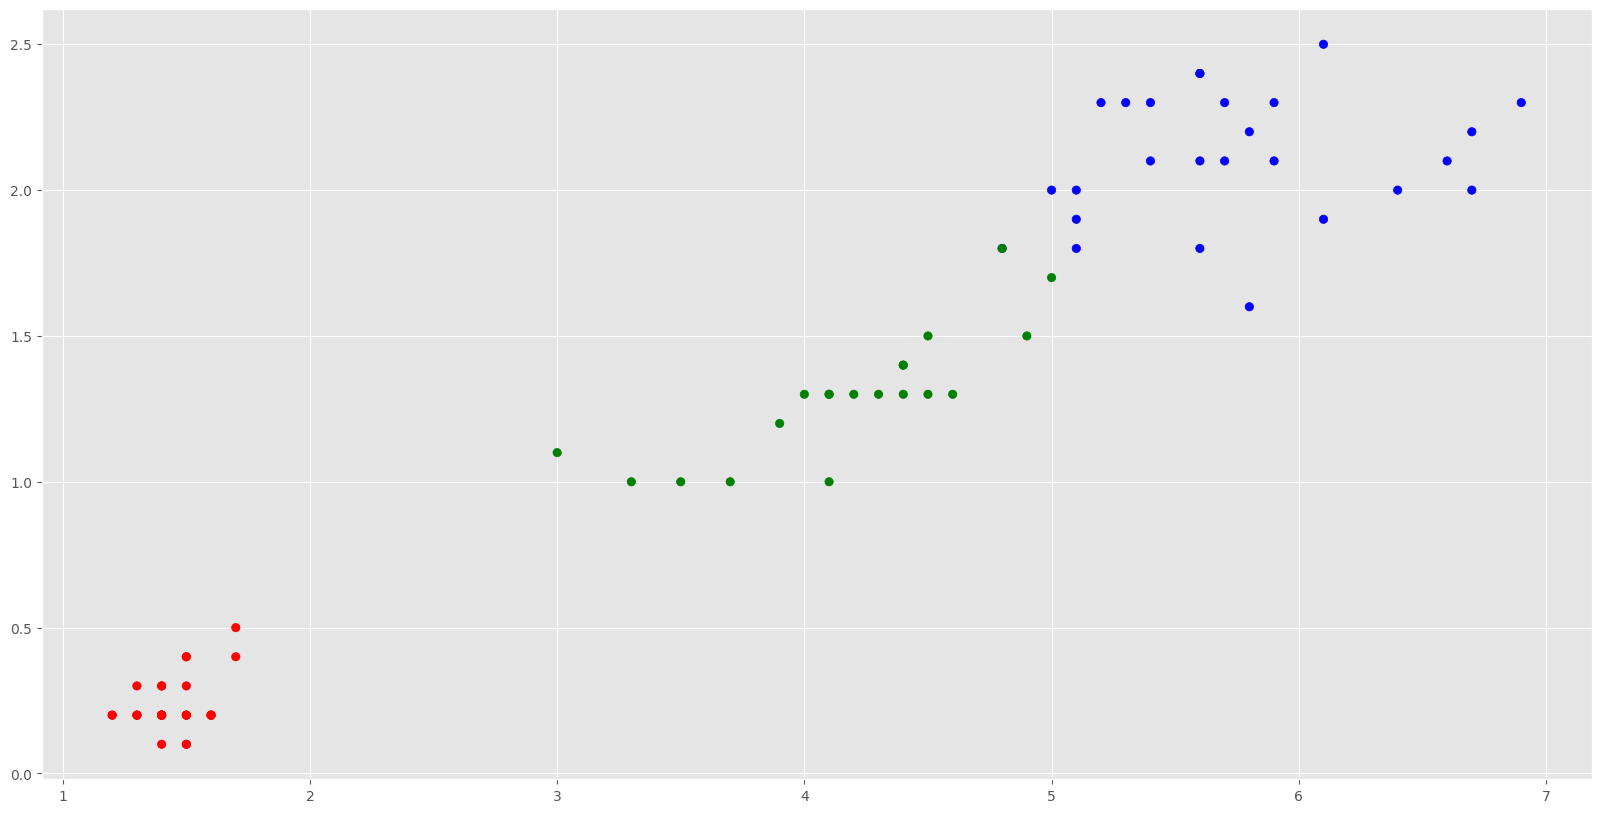

In [6]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

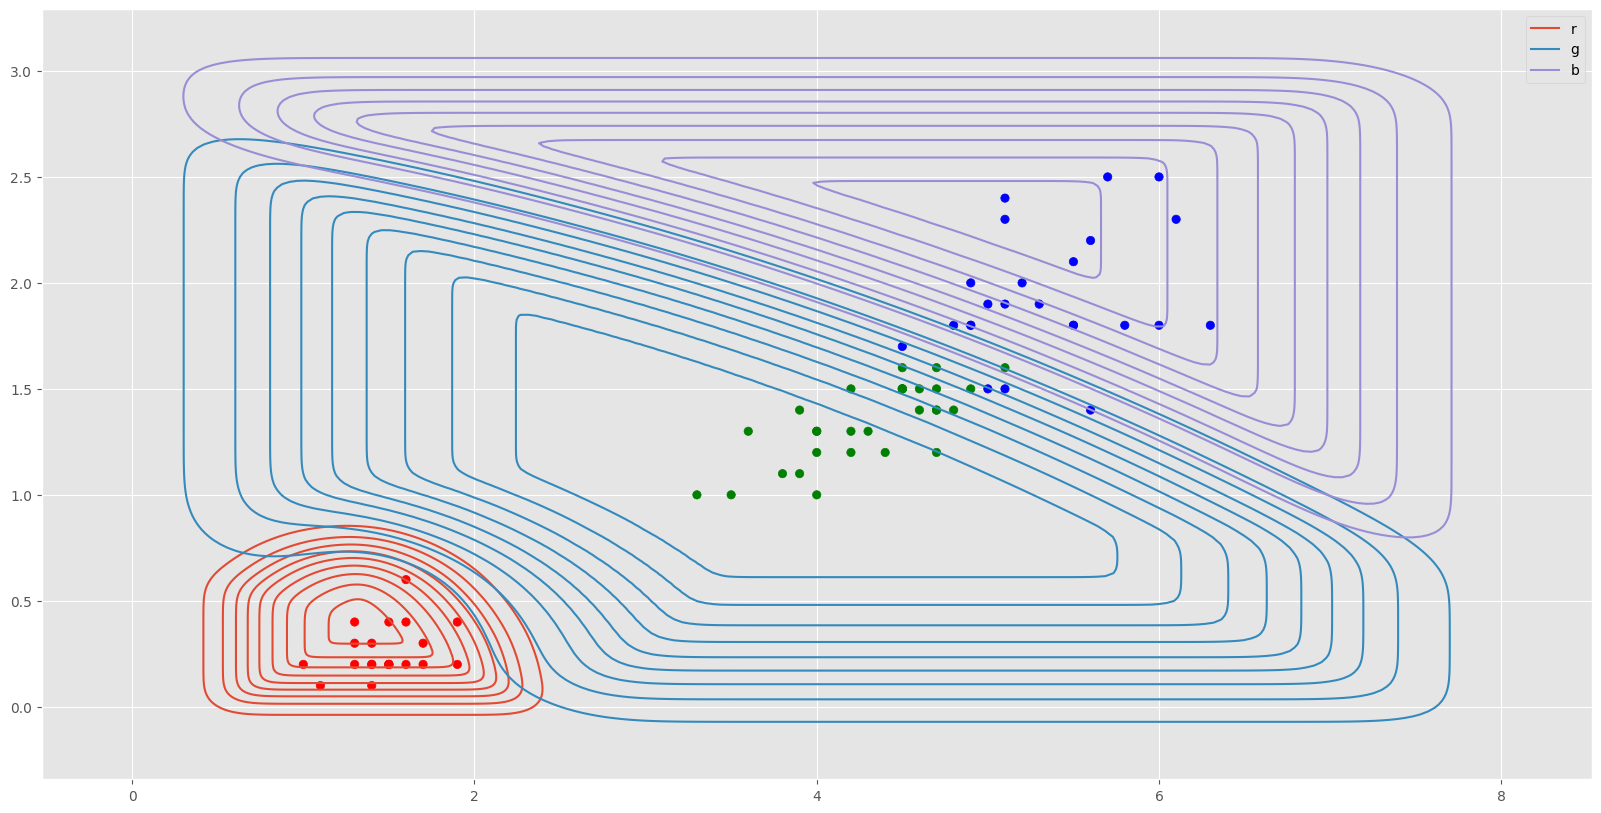

In [7]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

In [8]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [12]:
SAMPLES_COMP = 3131 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2955 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 66  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 9  #@param {type: "slider", min: 4, max: 20}

In [13]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
11455,1602.04805v1,Performing exact posterior inference in comple...,stat,DR-ABC: Approximate Bayesian Computation with ...,2016,"[performing, generative, impossible, intractab..."
32244,1401.1123v1,Motivated by applications in energy management...,cs,Exploration vs Exploitation vs Safety: Risk-av...,2014,"[applications, management, exploration, condit..."
38442,1801.05617v1,While social media offer great communication o...,cs,Automatic Detection of Cyberbullying in Social...,2018,"[communication, opportunities, vulnerability, ..."
22952,1711.08042v2,Most research on the interpretability of machi...,stat,"""I know it when I see it"". Visualization and I...",2017,"[interpretability, development, interpretabili..."
3967,0804.0352v1,This paper describes application of informatio...,cs,Permeability Analysis based on information gra...,2008,"[application, information, granulation, organi..."
...,...,...,...,...,...,...
7076,1709.10152v1,We present the first model and algorithm for L...,stat,L1-norm Kernel PCA,2017,"[understandings, reformulations, applicable, e..."
36368,1302.1530v1,This paper introduces a new algorithm for the ...,cs,Efficient Induction of Finite State Automata,2013,"[introduces, information, principles, previous..."
13734,1404.4067v1,The supplier selection problem is based on ele...,cs,An effective AHP-based metaheuristic approach ...,2014,"[candidates, identified, proportionately, sign..."
22581,1701.06749v1,Heavy-tailed distributions are widely used in ...,stat,Robust mixture modelling using sub-Gaussian st...,2017,"[distributions, possessing, computationally, d..."


In [14]:
df['keywords']

11455    [performing, generative, impossible, intractab...
32244    [applications, management, exploration, condit...
38442    [communication, opportunities, vulnerability, ...
22952    [interpretability, development, interpretabili...
3967     [application, information, granulation, organi...
                               ...                        
34437    [recognizing, normalizing, expressions, perfor...
816      [regularization, prediction, regularization, d...
22073    [dimensional, stationary, generalization, intr...
6613     [implementation, optimization, categorical, pe...
30530    [convolution, exceptionally, architecture, par...
Name: keywords, Length: 6086, dtype: object

In [15]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 6389 words.
Out of those 324 have over 66 occurances


In [16]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (324,), (324, 2))

In [17]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7430213464696224


In [18]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [20]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [21]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [22]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [23]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	extraction (0.0528)
	processing (0.098)
	evaluation (0.0964)
	representation (0.1268)
	experimental (0.1288)
	segmentation (0.0656)
	architecture (0.0876)
	information (0.246)
	convolutional (0.128)
	recognition (0.1384)

Some Statistics words are:
	convergence (0.11402027027027027)
	likelihood (0.0945945945945946)
	variational (0.0945945945945946)
	stochastic (0.1258445945945946)
	theoretical (0.14484797297297297)
	statistical (0.1579391891891892)
	estimation (0.17483108108108109)
	distribution (0.18243243243243243)
	dimensional (0.1866554054054054)
	regression (0.17863175675675674)


In [24]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [25]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	
Some words which never appear in Statistics papers:
	


0.0028036645079766226


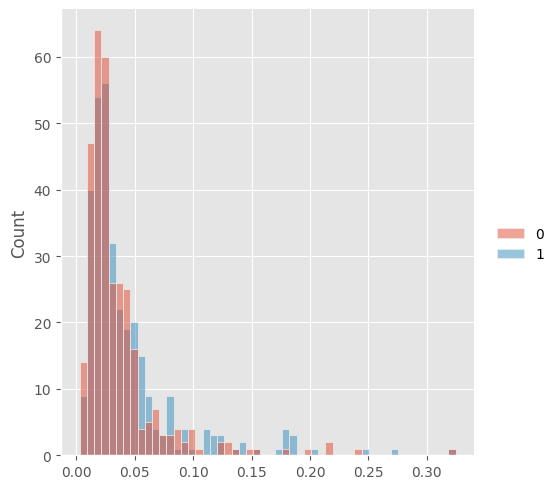

In [26]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [27]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7446633825944171
